In [84]:
#import packages and libraries
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report


# The CSV's first column is an index and Pandas will duplicate this and create an column without 'index_col=0'
df = pd.read_csv('medical_clean.csv', index_col=0)
# Check data types and number of values, as well as overall size of dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_id         10000 non-null  object 
 1   Interaction         10000 non-null  object 
 2   UID                 10000 non-null  object 
 3   City                10000 non-null  object 
 4   State               10000 non-null  object 
 5   County              10000 non-null  object 
 6   Zip                 10000 non-null  int64  
 7   Lat                 10000 non-null  float64
 8   Lng                 10000 non-null  float64
 9   Population          10000 non-null  int64  
 10  Area                10000 non-null  object 
 11  TimeZone            10000 non-null  object 
 12  Job                 10000 non-null  object 
 13  Children            10000 non-null  int64  
 14  Age                 10000 non-null  int64  
 15  Income              10000 non-null  float64
 16  Marital  

In [85]:
#drop columns that are not related to the research question
df = df.drop(columns=['Customer_id', 'Interaction', 'UID', 'City', 'State', 'County', 'Zip', 'Lat', 'Lng', 'Population', 'TimeZone', 'Job', 'Income', 'Children', 'Marital', 'Doc_visits', 'Full_meals_eaten', 'vitD_supp','Soft_drink', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma', 'TotalCharge', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8'])

#visually inspect df to facilitate exploration, spot problems
pd.set_option('display.max_columns', None)
df

,Area,Age,Gender,ReAdmis,VitD_levels,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Services,Initial_days,Additional_charges
CaseOrder,,,,,,,,,,,,,,,,,
1,Suburban,53,Male,No,19.141466,Emergency Admission,Yes,No,Medium,No,Yes,Yes,No,Yes,Blood Work,10.585770,17939.403420
2,Urban,51,Female,No,18.940352,Emergency Admission,Yes,No,High,Yes,No,No,No,No,Intravenous,15.129562,17612.998120
3,Suburban,53,Female,No,18.057507,Elective Admission,Yes,No,Medium,Yes,No,Yes,No,No,Blood Work,4.772177,17505.192460
4,Suburban,78,Male,No,16.576858,Elective Admission,No,Yes,Medium,No,Yes,No,No,No,Blood Work,1.714879,12993.437350
5,Rural,22,Female,No,17.439069,Elective Admission,No,No,Low,No,No,No,Yes,No,CT Scan,1.254807,3716.525786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,Urban,25,Male,No,16.980860,Emergency Admission,Yes,No,Medium,No,No,No,No,No,Intravenous,51.561220,8927.642000
9997,Urban,87,Male,Yes,18.177020,Elective Admission,Yes,No,Medium,Yes,Yes,Yes,No,No,CT Scan,68.668240,28507.150000
9998,Rural,45,Female,Yes,17.129070,Elective Admission,Yes,No,High,Yes,No,No,No,No,Intravenous,70.154180,15281.210000


In [86]:
#detection of duplicates True is missing value detected
df.duplicated()

CaseOrder
1        False
2        False
3        False
4        False
5        False
         ...  
9996     False
9997     False
9998     False
9999     False
10000    False
Length: 10000, dtype: bool

In [87]:
#count True and False together
print(df.duplicated().value_counts())

False    10000
Name: count, dtype: int64


In [88]:
#detect missing values
df.isnull().sum()

Area                  0
Age                   0
Gender                0
ReAdmis               0
VitD_levels           0
Initial_admin         0
HighBlood             0
Stroke                0
Complication_risk     0
Overweight            0
Arthritis             0
Diabetes              0
Hyperlipidemia        0
BackPain              0
Services              0
Initial_days          0
Additional_charges    0
dtype: int64

In [89]:
#check for outliers and remove
print(df.shape)
df = df[(np.abs(stats.zscore(df.select_dtypes(include=np.number))) < 3).all(axis=1)]
print(df.shape)

(10000, 17)
(9976, 17)


In [90]:
#convert ReAdmis, Stroke, Arthritis, Diabetes, HighBlood, Overweight, Hyperlipidemia, and BackPain from string to boolean
bool_mapping = {"Yes": 1, "No": 0}

columns_to_convert = ["ReAdmis", "Stroke", "Arthritis", "Diabetes", "HighBlood", "Overweight", "Hyperlipidemia", "BackPain"]
for column in columns_to_convert:
    df.loc[:, column] = df[column].map(bool_mapping)

#convert Area, Gender, Initial_admin, Complication_risk, Services to category from string
category_columns = ["Area", "Gender", "Initial_admin", "Complication_risk", "Services"]
for column in category_columns:
    df.loc[:, column] = df[column].astype("category")

In [91]:
#get summary statistics for quantitative variables 
df.describe()

,Age,VitD_levels,Initial_days,Additional_charges
count,9976.000000,9976.000000,9976.000000,9976.000000
mean,53.499599,17.961542,34.442217,12928.740381
std,20.643570,1.992118,26.307773,6542.851751
min,18.000000,11.966340,1.001981,3125.703000
25%,36.000000,16.629534,7.896215,7977.009525
50%,53.000000,17.950096,34.446941,11564.474150
75%,71.000000,19.342284,61.157380,15613.047345
max,89.000000,23.941426,71.981490,30566.070000


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'VitD_levels'}>],
       [<Axes: title={'center': 'Initial_days'}>,
        <Axes: title={'center': 'Additional_charges'}>]], dtype=object)

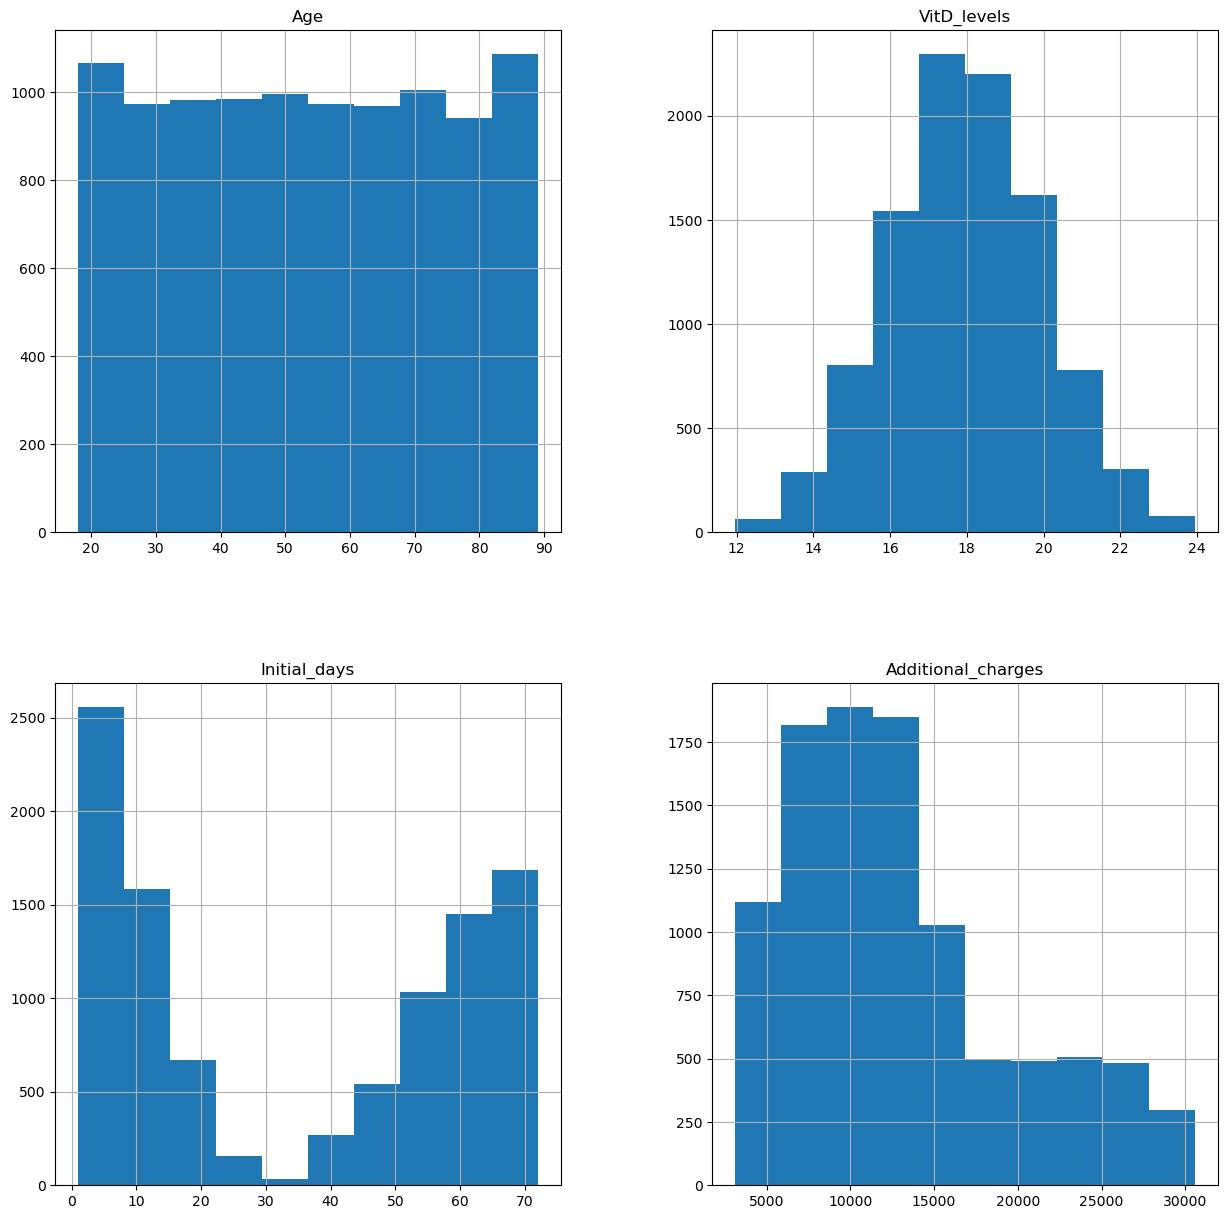

In [92]:
#distribution visualization
df.hist(figsize = (15,15))

In [93]:
#summary for categorical Area
df.Area.value_counts()

Area
Rural       3360
Suburban    3321
Urban       3295
Name: count, dtype: int64

In [94]:
#summary for categorical Gender
df.Gender.value_counts()

Gender
Female       5002
Male         4761
Nonbinary     213
Name: count, dtype: int64

In [95]:
#summary for categorica ReAdmis
df.ReAdmis.value_counts()

ReAdmis
0    6317
1    3659
Name: count, dtype: int64

In [96]:
#summary for categorical Initial_admin
df.Initial_admin.value_counts()

Initial_admin
Emergency Admission      5052
Elective Admission       2495
Observation Admission    2429
Name: count, dtype: int64

In [97]:
#summary for categorical HighBlood
df.HighBlood.value_counts()

HighBlood
0    5900
1    4076
Name: count, dtype: int64

In [98]:
#summary for categorical Stroke
df.Stroke.value_counts()

Stroke
0    7988
1    1988
Name: count, dtype: int64

In [99]:
#summary for categorical Complication_risk
df.Complication_risk.value_counts()

Complication_risk
Medium    4507
High      3350
Low       2119
Name: count, dtype: int64

In [100]:
#summary for categorical Overweight
df.Overweight.value_counts()

Overweight
1    7078
0    2898
Name: count, dtype: int64

In [101]:
#summary for categorical Arthritis
df.Arthritis.value_counts()

Arthritis
0    6410
1    3566
Name: count, dtype: int64

In [102]:
#summary for categorical Diabetes
df.Diabetes.value_counts()

Diabetes
0    7240
1    2736
Name: count, dtype: int64

In [103]:
#summary for Hyperlipidemia
df.Hyperlipidemia.value_counts()

Hyperlipidemia
0    6611
1    3365
Name: count, dtype: int64

In [104]:
#summary for BackPain
df.BackPain.value_counts()

BackPain
0    5871
1    4105
Name: count, dtype: int64

In [105]:
#summary for Services
df.Services.value_counts()

Services
Blood Work     5257
Intravenous    3123
CT Scan        1219
MRI             377
Name: count, dtype: int64

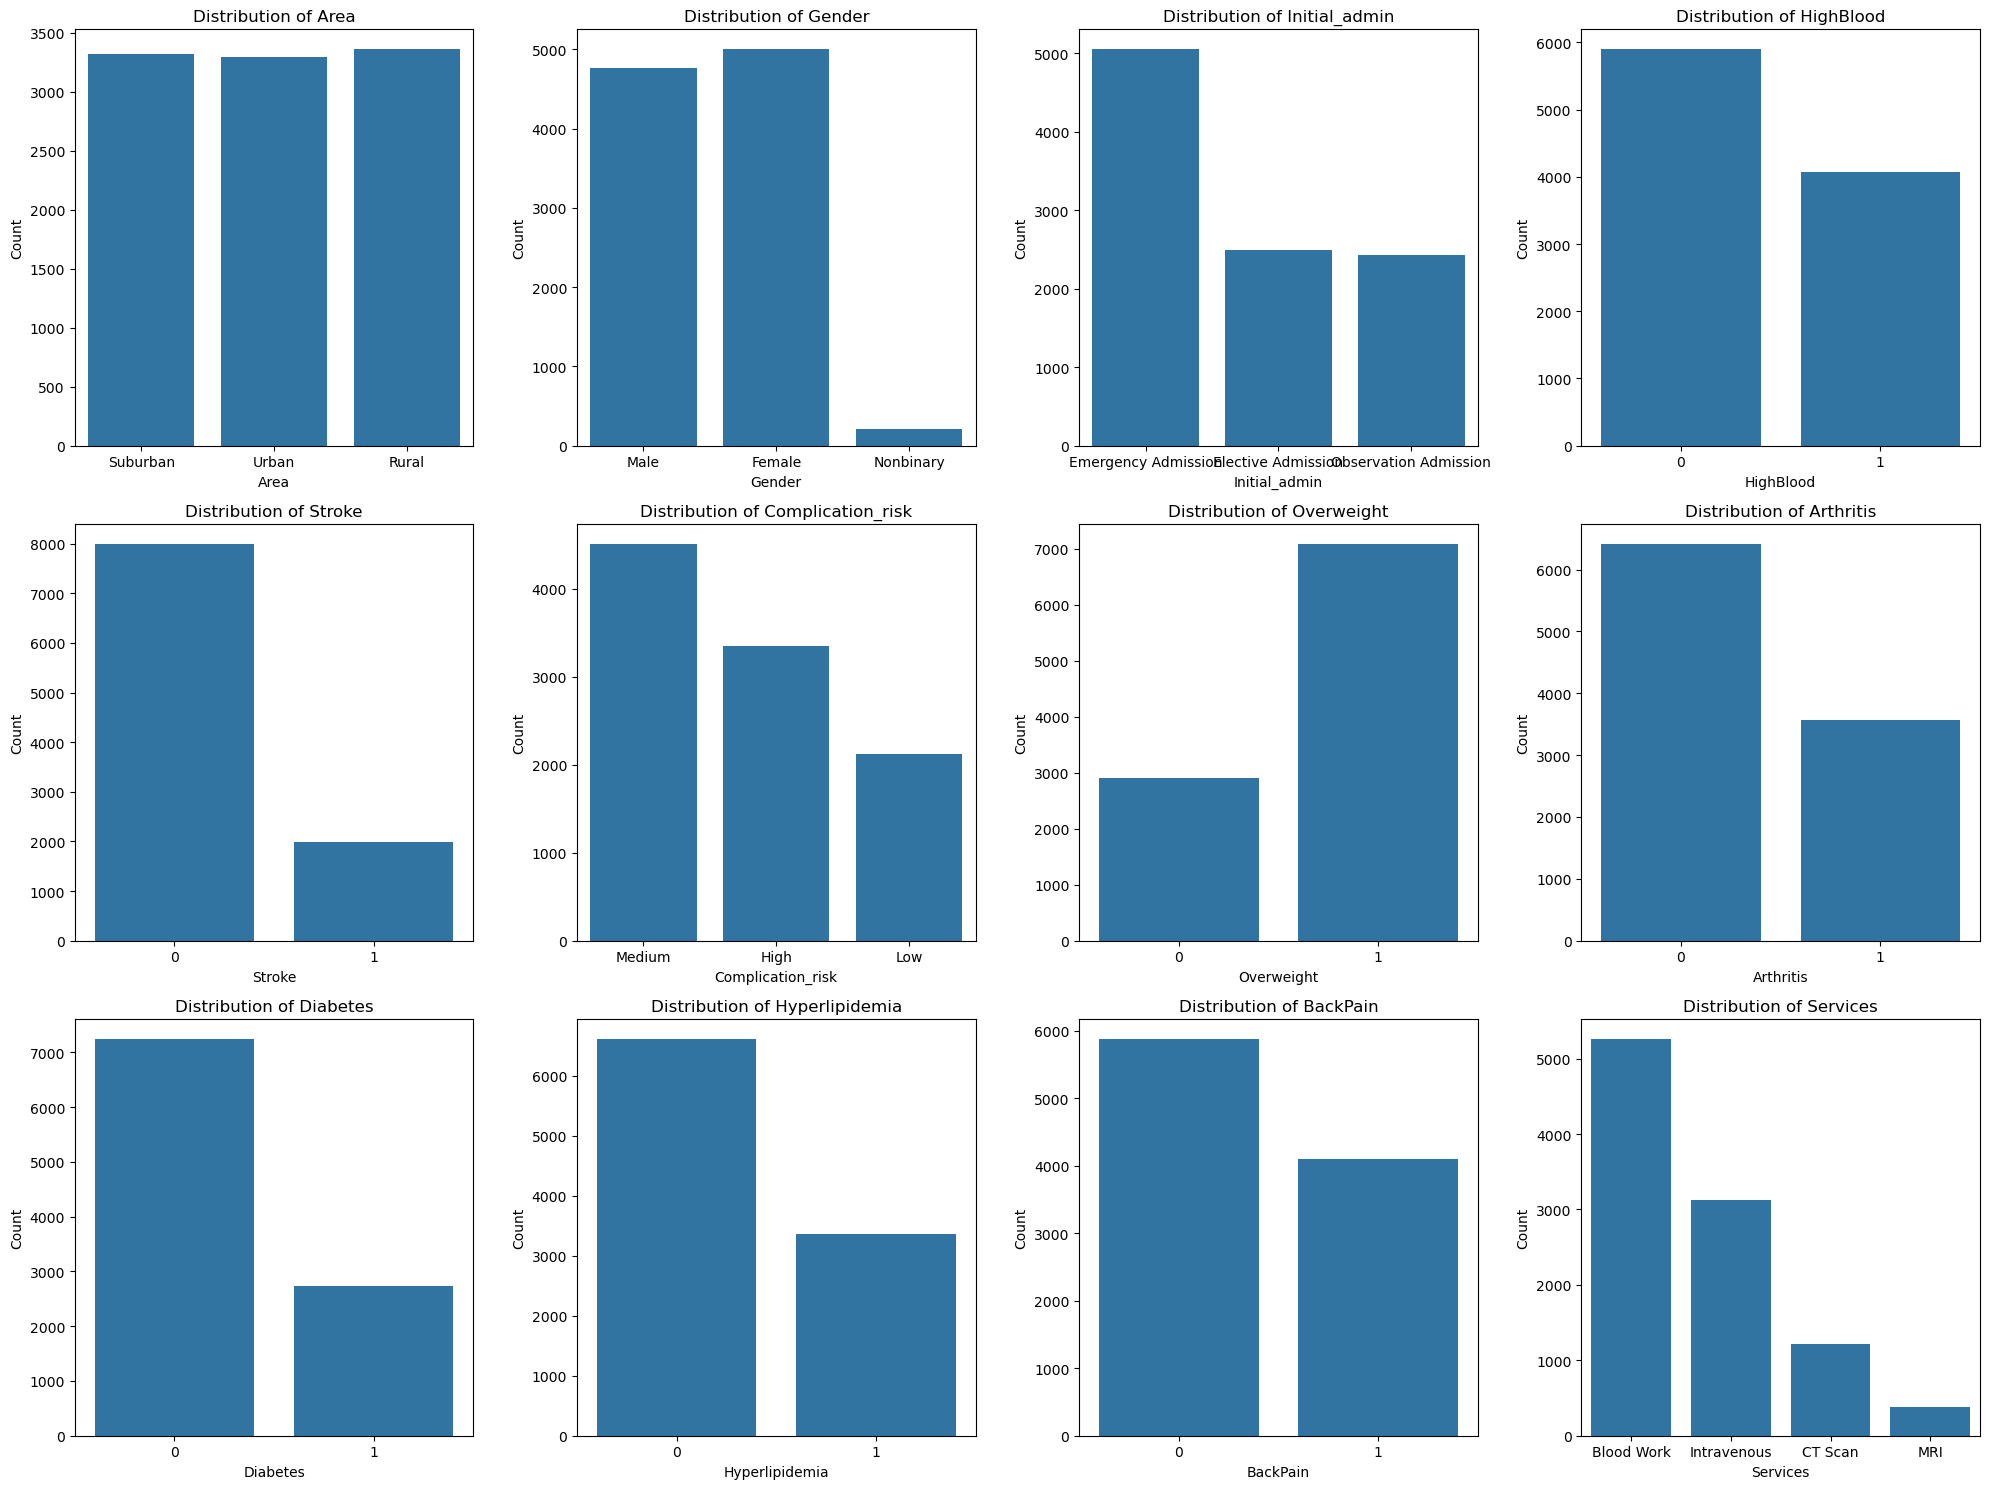

In [106]:
#list of categorical variables
categorical_vars = ['Area', 'Gender', 'Initial_admin', 'HighBlood', 'Stroke', 'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia', 'BackPain', 'Services']

#set up the matplotlib figure with a grid layout
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

#flatten the axes array for easy iteration
axes = axes.flatten()

#create bar plots for each categorical variable
for i, var in enumerate(categorical_vars):
    sns.countplot(data=df, x=var, ax=axes[i])
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

#remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [107]:
#generate column names which are pythonic in syntax and descriptive
pythonic_columns = ['area_type', 'age', 'gender', 'readmission', 'vitamin_d_level', 'initial_admission_type', 'high_bp', 'stroke', 'complication_risk', 'overweight', 'arthritis', 'diabetes', 'hyperlipidemia', 'back_pain', 'services_type', 'days_hospitalized', 'additional_charges' ]

#implement new pythonic column headings
df.columns = pythonic_columns

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9976 entries, 1 to 10000
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   area_type               9976 non-null   object 
 1   age                     9976 non-null   int64  
 2   gender                  9976 non-null   object 
 3   readmission             9976 non-null   object 
 4   vitamin_d_level         9976 non-null   float64
 5   initial_admission_type  9976 non-null   object 
 6   high_bp                 9976 non-null   object 
 7   stroke                  9976 non-null   object 
 8   complication_risk       9976 non-null   object 
 9   overweight              9976 non-null   object 
 10  arthritis               9976 non-null   object 
 11  diabetes                9976 non-null   object 
 12  hyperlipidemia          9976 non-null   object 
 13  back_pain               9976 non-null   object 
 14  services_type           9976 non-null   obje

In [109]:
#set the pandas option to opt-in to the future behavior
pd.set_option('future.no_silent_downcasting', True)

#One Hot Encoding using get_dummies
df = pd.get_dummies(df, columns=['area_type', 'gender', 'initial_admission_type', 'complication_risk', 'services_type'])

#replace boolean values with integers
df = df.replace({True: 1, False: 0})

#convert all columns to numeric
df = df.apply(pd.to_numeric, axis=0)


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9976 entries, 1 to 10000
Data columns (total 28 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   age                                           9976 non-null   int64  
 1   readmission                                   9976 non-null   int64  
 2   vitamin_d_level                               9976 non-null   float64
 3   high_bp                                       9976 non-null   int64  
 4   stroke                                        9976 non-null   int64  
 5   overweight                                    9976 non-null   int64  
 6   arthritis                                     9976 non-null   int64  
 7   diabetes                                      9976 non-null   int64  
 8   hyperlipidemia                                9976 non-null   int64  
 9   back_pain                                     9976 non-null   int64

In [111]:
#separate the X explanatory variables from the response Y variable readmission into different dataframes
df_X = df.drop(['readmission'], axis=1).copy()
df_y = df['readmission'].copy()
print(df_X.shape)
print(df_y.shape)

(9976, 27)
(9976,)


In [112]:
#standardize the X variables to put all on the same scale for KNN to measure distance
df_X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df_X), columns=df_X.columns)
df_X

,age,vitamin_d_level,high_bp,stroke,overweight,arthritis,diabetes,hyperlipidemia,back_pain,days_hospitalized,additional_charges,area_type_Rural,area_type_Suburban,area_type_Urban,gender_Female,gender_Male,gender_Nonbinary,initial_admission_type_Elective Admission,initial_admission_type_Emergency Admission,initial_admission_type_Observation Admission,complication_risk_High,complication_risk_Low,complication_risk_Medium,services_type_Blood Work,services_type_CT Scan,services_type_Intravenous,services_type_MRI
0,0.492958,0.599171,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.135022,0.539851,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.464789,0.582377,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.199037,0.527956,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.492958,0.508653,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.053117,0.524027,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.845070,0.385009,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.010044,0.359607,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.056338,0.457010,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.003562,0.021531,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9971,0.098592,0.418746,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.712308,0.211438,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9972,0.971831,0.518633,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.953321,0.924967,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9973,0.380282,0.431123,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.974256,0.442979,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9974,0.352113,0.663385,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.878492,0.169676,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [113]:
df_y

CaseOrder
1        0
2        0
3        0
4        0
5        0
        ..
9996     0
9997     1
9998     1
9999     1
10000    1
Name: readmission, Length: 9976, dtype: int64

In [114]:
#prepared dataset to csv file
df.to_csv('D209_task1.csv', index=False)

In [115]:
#use SelectKBest to determine the best variables to include in the model 
feat_select = SelectKBest(f_classif, k='all')
feat_select.fit_transform(df_X, df_y)
feat_pvals = pd.DataFrame({'Feature' : df_X.columns, 'p_value' : feat_select.pvalues_}).sort_values('p_value') 
feat_pvals[feat_pvals['p_value'] < 0.05] 

,Feature,p_value
9,days_hospitalized,0.000000
24,services_type_CT Scan,0.011382
18,initial_admission_type_Emergency Admission,0.041634
25,services_type_Intravenous,0.041720


In [116]:
#check VIF for multicollinearity issues amongst these variables
X = df[['days_hospitalized', 'services_type_CT Scan', 'initial_admission_type_Emergency Admission', 'services_type_Intravenous']]

vif_df = pd.DataFrame()
vif_df['feature'] = X.columns

vif_df['VIF'] = [variance_inflation_factor(X.values, i)
for i in range(len(X.columns))]

print(vif_df)

                                      feature       VIF
0                           days_hospitalized  1.664670
1                       services_type_CT Scan  1.136615
2  initial_admission_type_Emergency Admission  1.558100
3                   services_type_Intravenous  1.327574


In [117]:
#set X and y (standard sklearn variables) to equal the selected X features and the y response of interest
X = df_X[['days_hospitalized', 'services_type_CT Scan', 'initial_admission_type_Emergency Admission', 'services_type_Intravenous']]
y = df_y
#split the data into train and test sets (80% train/20% test) use stratify to maintain proportions across split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state = 42, stratify = y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7980, 4)
(1996, 4)
(7980,)
(1996,)


In [118]:
#save each of the four data sets to CSV files
X_train.to_csv('task1_Xtrain.csv', index=False)
X_test.to_csv('task1_Xtest.csv', index=False)
y_train.to_csv('task1_ytrain.csv', index=False)
y_test.to_csv('task1_ytest.csv', index=False)

In [119]:
#run GridSearchCV to find best number of k
param_grid = {'n_neighbors': np.arange(1, 50)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid)
knn_cv.fit(X_train, y_train)
print('The best parameters for this model: {}'.format(knn_cv.best_params_))

#calculate the mean score (for the best parameter setting found by the GridSearch)
mean_score = knn_cv.cv_results_['mean_test_score'][knn_cv.best_index_]
print('Mean score: {}'.format(mean_score))

The best parameters for this model: {'n_neighbors': 11}
Mean score: 0.9814536340852131


In [120]:
#perform KNN using the k=11 
knn = KNeighborsClassifier(n_neighbors = 11)

#fit to the training data
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
final_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1264
           1       0.96      0.97      0.97       732

    accuracy                           0.98      1996
   macro avg       0.97      0.98      0.98      1996
weighted avg       0.98      0.98      0.98      1996



In [121]:
#print accuracy of the model
print("The accuracy of the model is: ", knn.score(X_test, y_test))

The accuracy of the model is:  0.9769539078156313


In [122]:
#print confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[1238   26]
 [  20  712]]


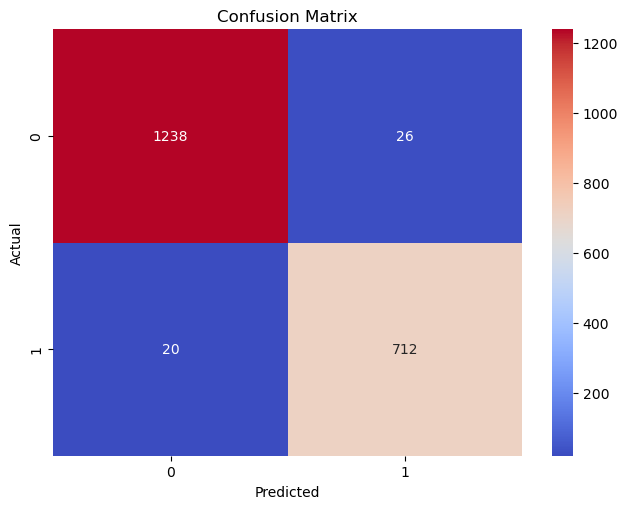

In [123]:
#use seaborn heatmap to visualize the confusion matrix
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, fmt = 'g', cmap='coolwarm')
plt.tight_layout()
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('matrix1.jpg')

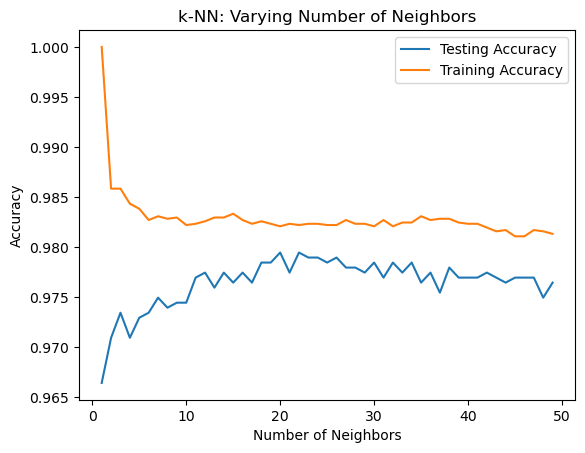

In [124]:
#model complexity curve
neighbors = np. arange(1, 50)
train_accuracy = np.empty (len (neighbors))
test_accuracy = np.empty (len (neighbors))

#loop over different values of k
for i, k in enumerate (neighbors):
    
#setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier (n_neighbors=k)

#fit the classifier to the training data
    knn.fit (X_train,y_train)

#compute accuracy on the training set
    train_accuracy[i] = knn.score (X_train, y_train)

#compute accuracy on the testing set
    test_accuracy[i] = knn. score (X_test, y_test)

#generate plot
plt.title ('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot (neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [125]:
#print accuracy on train and test sets
print("Train Accuracy:", train_accuracy[i], "Test Accuracy:", test_accuracy[i])

Train Accuracy: 0.981328320802005 Test Accuracy: 0.9764529058116233


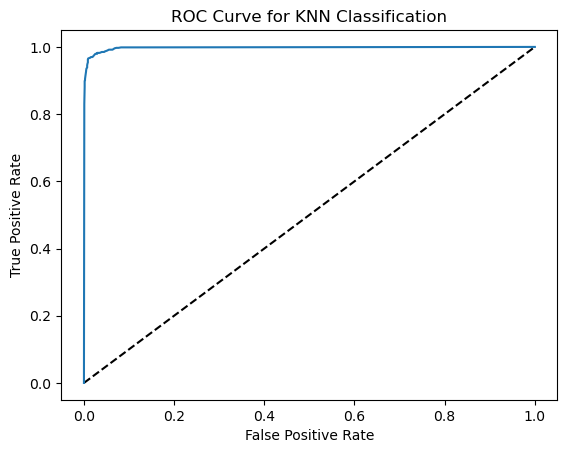

The Area Under the Curve (AUC) score is: 0.9971829174448366



In [126]:
#generate AUC score and print
y_pred_prob = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN Classification')
plt.show()
print(f"The Area Under the Curve (AUC) score is: {roc_auc_score(y_test, y_pred_prob)}\n")